#PCA

Base de datos: https://physionet.org/content/treadmill-exercise-cardioresp/1.0.1/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Librerias

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Datos
El set de datos Treadmill contiene las mediciones cardiorrespiratorias de 992 pruebas de esfuerzo máximo en cinta (2008-2018) realizadas en la Universidad de Málaga. Incluye la frecuencia cardíaca (HeartRate), el consumo de oxígeno (OxygenConsumption), la producción de dióxido de carbono (CarbonDioxideGeneration), y la ventilación pulmonar (PulmonaryVentilation) medida respiración a respiración, junto con la velocidad de la cinta (Speed). También proporciona información sobre los participantes (ID), como edad (Age), altura (Height), peso (Weight), y condiciones ambientales (Temperature, Humidity) durante la prueba.

In [ ]:
test_measure = pd.read_csv('/content/drive/MyDrive/MA1001B.501/test_measure.csv')
datos_tm = test_measure

In [ ]:
datos_tm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575087 entries, 0 to 575086
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   time     575087 non-null  int64  
 1   Speed    575087 non-null  float64
 2   HR       574106 non-null  float64
 3   VO2      570216 non-null  float64
 4   VCO2     570216 non-null  float64
 5   RR       575087 non-null  int64  
 6   VE       575087 non-null  float64
 7   ID_test  575087 non-null  object 
 8   ID       575087 non-null  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 39.5+ MB


In [ ]:
test_measure.isnull().sum()

,0
time,0
Speed,0
HR,981
VO2,4871
VCO2,4871
RR,0
VE,0
ID_test,0
ID,0


In [ ]:
datos_tm.head(4)

,time,Speed,HR,VO2,VCO2,RR,VE,ID_test,ID
0,0,5.0,63.0,478.0,360.0,27,13.3,2_1,2
1,2,5.0,75.0,401.0,295.0,23,10.3,2_1,2
2,4,5.0,82.0,449.0,319.0,29,12.2,2_1,2
3,7,5.0,87.0,461.0,340.0,28,12.8,2_1,2


In [ ]:
subject_info = pd.read_csv('/content/drive/MyDrive/MA1001B.501/subject-info.csv')
datos_si = subject_info

In [ ]:
datos_si.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          992 non-null    float64
 1   Weight       992 non-null    float64
 2   Height       992 non-null    float64
 3   Humidity     962 non-null    float64
 4   Temperature  962 non-null    float64
 5   Sex          992 non-null    int64  
 6   ID           992 non-null    int64  
 7   ID_test      992 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 62.1+ KB


In [ ]:
subject_info.isnull().sum()

,0
Age,0
Weight,0
Height,0
Humidity,30
Temperature,30
Sex,0
ID,0
ID_test,0


In [ ]:
datos_si.head(4)

,Age,Weight,Height,Humidity,Temperature,Sex,ID,ID_test
0,10.8,48.8,163.0,39.0,20.7,1,543,543_1
1,11.8,41.0,150.0,41.0,22.3,1,11,11_1
2,12.2,46.0,160.0,37.0,21.5,0,829,829_1
3,13.2,71.0,190.0,49.0,23.8,1,284,284_1


# Limpiando valores nulos

Usaremos el método K-Nearest Neighbors (KNN) con k=5 para los valores nulos

In [ ]:

imputer = KNNImputer(n_neighbors=5)

#test_measure
test_measure_numeric = test_measure.drop(columns=['ID', 'ID_test']).select_dtypes(include=[float, int])
test_measure_imputed = pd.DataFrame(imputer.fit_transform(test_measure_numeric), columns=test_measure_numeric.columns)
datos_tm[test_measure_imputed.columns] = test_measure_imputed

#subject_info
subject_info_numeric = subject_info.drop(columns=['ID', 'ID_test', 'Sex']).select_dtypes(include=[float, int])
subject_info_imputed = pd.DataFrame(imputer.fit_transform(subject_info_numeric), columns=subject_info_numeric.columns)
datos_si[subject_info_imputed.columns] = subject_info_imputed

In [ ]:
print("Valores nulos en test_measure después de KNN:")
print(datos_tm.isnull().sum())

print("Valores nulos en subject_info después de KNN:")
print(datos_si.isnull().sum())


Valores nulos en test_measure después de KNN:
time       0
Speed      0
HR         0
VO2        0
VCO2       0
RR         0
VE         0
ID_test    0
ID         0
dtype: int64
Valores nulos en subject_info después de KNN:
Age            0
Weight         0
Height         0
Humidity       0
Temperature    0
Sex            0
ID             0
ID_test        0
dtype: int64


##Exploración inicial


In [ ]:
print('----------------------')
print('Media de cada variable \n en test measure')
print('----------------------')
print(datos_tm.drop(columns=['ID_test']).mean(axis=0))

----------------------
Media de cada variable 
 en test measure
----------------------
time      628.126172
Speed       9.607958
HR        146.859737
VO2      2311.121681
VCO2     2387.100996
RR         36.491513
VE         69.304931
ID        425.424579
dtype: float64


In [ ]:
print('-------------------------')
print('Varianza de cada variable \n en test measure')
print('-------------------------')
print(datos_tm.drop(columns=['ID_test']).var(axis=0))

-------------------------
Varianza de cada variable 
 en test measure
-------------------------
time     1.060081e+05
Speed    2.043387e+01
HR       1.040495e+03
VO2      9.587907e+05
VCO2     1.346684e+06
RR       1.482853e+02
VE       1.126178e+03
ID       6.024251e+04
dtype: float64


In [ ]:
print('----------------------')
print('Media de cada variable \n en subject info')
print('----------------------')
print(datos_si.drop(columns=['ID_test']).mean(axis=0))

----------------------
Media de cada variable 
 en subject info
----------------------
Age             28.979133
Weight          73.383367
Height         174.913508
Humidity        48.206835
Temperature     22.819817
Sex              0.150202
ID             424.890121
dtype: float64


In [ ]:
print('-------------------------')
print('Varianza de cada variable \n en subject info')
print('-------------------------')
print(datos_si.drop(columns=['ID_test']).var(axis=0))

-------------------------
Varianza de cada variable 
 en subject info
-------------------------
Age              101.538928
Weight           144.128694
Height            63.202925
Humidity          71.564071
Temperature        7.553830
Sex                0.127770
ID             59454.277521
dtype: float64


##Modelo PCA





In [ ]:
# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
datos_tm_numeric = datos_tm.drop(columns=['ID', 'ID_test'])

pca_pipe_tm = make_pipeline(StandardScaler(), PCA())
pca_pipe_tm.fit(datos_tm_numeric)

# Se extrae el modelo entrenado del pipeline (1)
modelo_pca_tm = pca_pipe_tm.named_steps['pca']





In [ ]:
# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
datos_si_numeric = datos_si.drop(columns=['ID', 'ID_test', 'Sex'])

pca_pipe_si = make_pipeline(StandardScaler(), PCA())
pca_pipe_si.fit(datos_si_numeric)

# Se extrae el modelo entrenado del pipeline(1)
modelo_pca_si= pca_pipe_si.named_steps['pca']


##Interpretación


In [ ]:
# Se combierte el array a dataframe para añadir nombres a los ejes.

componentes_tm = pd.DataFrame(
    data    = modelo_pca_tm.components_,
    columns = datos_tm_numeric.columns,  # Usar las columnas procesadas en PCA
    index   = [f'PC{i+1}' for i in range(modelo_pca_tm.n_components_)]
)

print(componentes_tm)

         time     Speed        HR       VO2      VCO2        RR        VE
PC1  0.302771  0.353651  0.381640  0.403596  0.416362  0.354409  0.419236
PC2  0.803382 -0.531305 -0.067401 -0.236634  0.021057  0.050322  0.093697
PC3 -0.102288  0.047219  0.146322 -0.386283 -0.336550  0.833040 -0.097271
PC4  0.272827  0.300309  0.697607 -0.186602 -0.254602 -0.338289 -0.366937
PC5  0.398411  0.678517 -0.580926 -0.062627 -0.165898  0.003671 -0.109321
PC6  0.136849 -0.194335 -0.046662  0.711113 -0.173979  0.225967 -0.595246
PC7 -0.023477  0.045613 -0.045706 -0.295765  0.768323  0.111321 -0.552349


In [ ]:
# Se convierte el array a dataframe para añadir nombres a los ejes.
componentes_si = pd.DataFrame(
    data    = modelo_pca_si.components_,
    columns = datos_si_numeric.columns,  # Usar las columnas procesadas en PCA
    index   = [f'PC{i+1}' for i in range(modelo_pca_si.n_components_)]
)

print(componentes_si)

          Age    Weight    Height  Humidity  Temperature
PC1  0.138274  0.710228  0.686482  0.024338    -0.067876
PC2 -0.554536 -0.003623  0.199899 -0.344618     0.730586
PC3 -0.598488 -0.009560  0.091855  0.788495    -0.107517
PC4  0.526438  0.058663 -0.118336  0.505533     0.670712
PC5 -0.195052  0.701449 -0.682893 -0.057955     0.014940


##heatmap

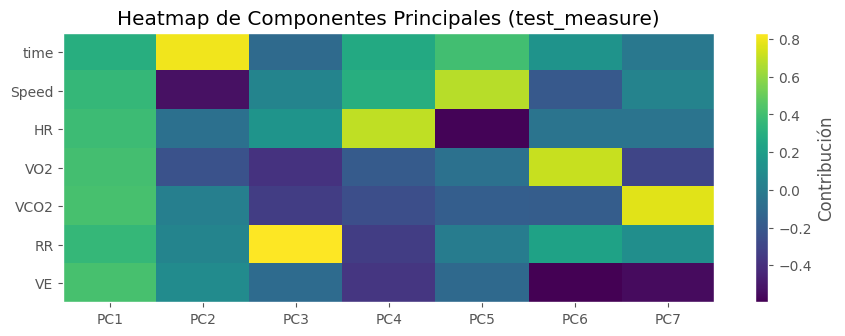

In [ ]:
# Heatmap componentes
# ==============================================================================

# Calcular tamaño dinámico del gráfico
num_variables = len(datos_tm_numeric.columns)  # Número de variables originales
num_components = modelo_pca_tm.n_components_  # Número de componentes principales

fig_width = num_components * 1.5  # Ancho proporcional al número de componentes
fig_height = num_variables * 0.5  # Altura proporcional al número de variables
fig_size = (fig_width, fig_height)

fig, ax = plt.subplots(figsize=fig_size)
plt.imshow(modelo_pca_tm.components_.T, cmap='viridis', aspect='auto')


plt.yticks(range(num_variables), datos_tm_numeric.columns)  # Etiquetas de variables
plt.xticks(range(num_components), [f'PC{i+1}' for i in range(num_components)])  # Etiquetas de componentes
plt.title('Heatmap de Componentes Principales (test_measure)')
plt.colorbar(label='Contribución')
plt.grid(False)
plt.show()


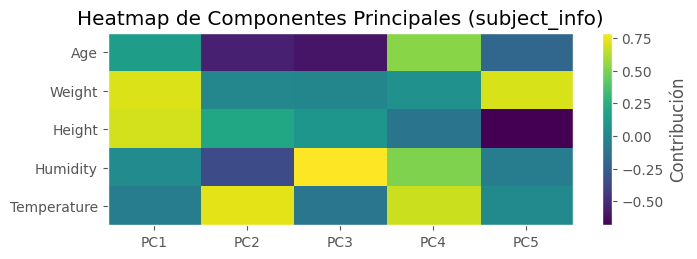

In [ ]:
# Heatmap componentes
# ==============================================================================
# Calcular tamaño dinámico del gráfico
num_variables_si = len(datos_si_numeric.columns)  # Número de variables originales
num_components_si = modelo_pca_si.n_components_  # Número de componentes principales

fig_width_si = num_components_si * 1.5  # Ancho proporcional al número de componentes
fig_height_si = num_variables_si * 0.5  # Altura proporcional al número de variables
fig_size_si = (fig_width_si, fig_height_si)

fig, ax = plt.subplots(figsize=fig_size_si)
plt.imshow(modelo_pca_si.components_.T, cmap='viridis', aspect='auto')

plt.yticks(range(num_variables_si), datos_si_numeric.columns)  # Etiquetas de variables
plt.xticks(range(num_components_si), [f'PC{i+1}' for i in range(num_components_si)])  # Etiquetas de componentes
plt.title('Heatmap de Componentes Principales (subject_info)')
plt.colorbar(label='Contribución')
plt.grid(False)
plt.show()

#Porcentaje de varianza explicada por cada componente

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.74714696 0.1001908  0.06287991 0.04056884 0.03693523 0.00844116
 0.00383711]


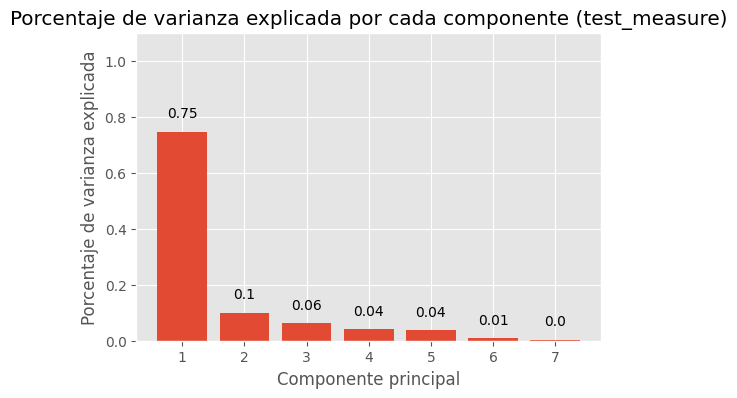

In [ ]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca_tm.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(
    x      = np.arange(modelo_pca_tm.n_components_) + 1,
    height = modelo_pca_tm.explained_variance_ratio_
)

for x, y in zip(np.arange(modelo_pca_tm.n_components_) + 1, modelo_pca_tm.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center'
    )
ax.set_xticks(np.arange(modelo_pca_tm.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente (test_measure)')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Porcentaje de varianza explicada')
plt.show()

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.33880763 0.23217795 0.21085235 0.16019062 0.05797145]


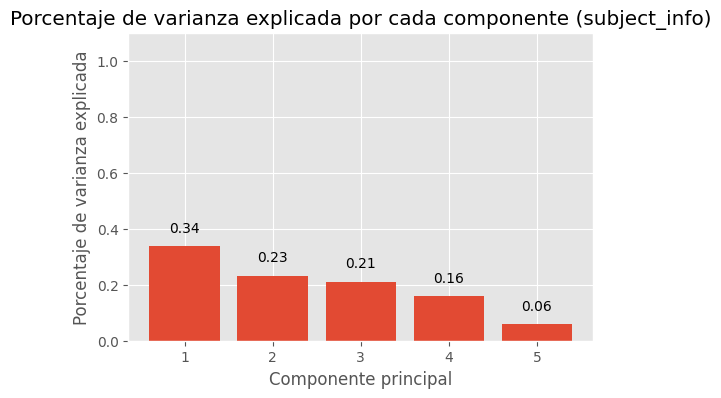

In [ ]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca_si.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(
    x      = np.arange(modelo_pca_si.n_components_) + 1,
    height = modelo_pca_si.explained_variance_ratio_
)

for x, y in zip(np.arange(modelo_pca_si.n_components_) + 1, modelo_pca_si.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca_si.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente (subject_info)')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Porcentaje de varianza explicada')
plt.show()


Porcentaje de varianza explicada acumulada

------------------------------------------
Porcentaje de varianza explicada acumulada (test_measure)
------------------------------------------
[0.74714696 0.84733776 0.91021767 0.9507865  0.98772173 0.99616289
 1.        ]


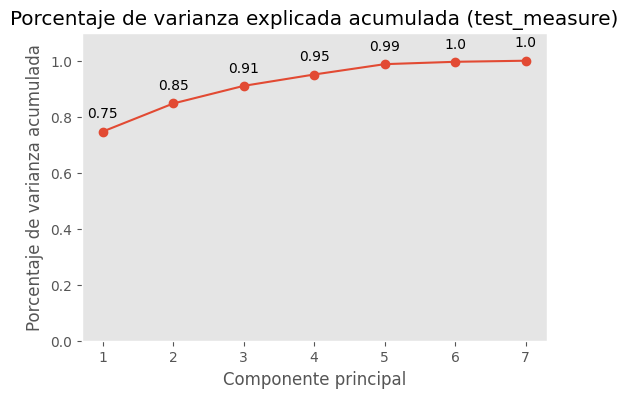

In [ ]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum_tm = modelo_pca_tm.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada (test_measure)')
print('------------------------------------------')
print(prop_varianza_acum_tm)

# Gráfico
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(
    np.arange(len(prop_varianza_acum_tm)) + 1,  # Índices de las componentes
    prop_varianza_acum_tm,                     # Varianza acumulada
    marker='o'
)

for x, y in zip(np.arange(len(prop_varianza_acum_tm)) + 1, prop_varianza_acum_tm):
    label = round(y, 2)  # Etiqueta con dos decimales
    ax.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center'
    )

ax.set_ylim(0, 1.1)  # Escala de 0 a 1.1 para incluir la etiqueta
ax.set_xticks(np.arange(len(prop_varianza_acum_tm)) + 1)  # Ticks en el eje x
ax.set_title('Porcentaje de varianza explicada acumulada (test_measure)')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Porcentaje de varianza acumulada')
plt.grid()
plt.show()


------------------------------------------
Porcentaje de varianza explicada acumulada (subject_info)
------------------------------------------
[0.33880763 0.57098558 0.78183793 0.94202855 1.        ]


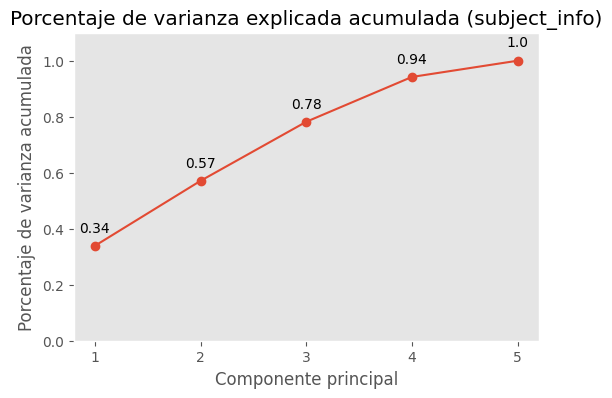

In [ ]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum_si = modelo_pca_si.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada (subject_info)')
print('------------------------------------------')
print(prop_varianza_acum_si)

# Gráfico
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(
    np.arange(len(prop_varianza_acum_si)) + 1,  # Índices de las componentes
    prop_varianza_acum_si,                     # Varianza acumulada
    marker='o'
)

for x, y in zip(np.arange(len(prop_varianza_acum_si)) + 1, prop_varianza_acum_si):
    label = round(y, 2)  # Etiqueta con dos decimales
    ax.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center'
    )

ax.set_ylim(0, 1.1)  # Escala de 0 a 1.1 para incluir la etiqueta
ax.set_xticks(np.arange(len(prop_varianza_acum_si)) + 1)  # Ticks en el eje x
ax.set_title('Porcentaje de varianza explicada acumulada (subject_info)')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Porcentaje de varianza acumulada')
plt.grid()
plt.show()

##Trasformación


Una vez entrenado el modelo, con el método transform() se puede reducir la dimensionalidad de nuevas observaciones proyectándolas en el espacio definido por las componentes.

In [ ]:
# Varianza acumulada - test_measure
varianza_acum_tm = modelo_pca_tm.explained_variance_ratio_.cumsum()
n_tm = sum(varianza_acum_tm <= 0.95) + 1  # Incluye la última componente que pasa el 95%
print(f"Número de componentes principales para test_measure: {n_tm}")


Número de componentes principales para test_measure: 4


In [ ]:
# Proyección de las observaciones de entrenamiento
# ==============================================================================
proyecciones_tm = pca_pipe_tm.transform(datos_tm_numeric)
proyecciones_tm_reducidas = pd.DataFrame(
    proyecciones_tm[:, :n_tm],  # Usar las primeras n_tm componentes
    columns=[f'PC{i+1}' for i in range(n_tm)],
    index=datos_tm_numeric.index
)

print(proyecciones_tm_reducidas.head())

        PC1       PC2       PC3       PC4
0 -4.395552 -0.622431  0.592865 -0.975956
1 -4.460670 -0.650048  0.430955 -0.541900
2 -4.149234 -0.640805  0.841135 -0.590707
3 -4.096415 -0.648826  0.781900 -0.465734
4 -3.938709 -0.675224  0.731826 -0.414033


In [ ]:
# Varianza acumulada - subject_info
varianza_acum_si = modelo_pca_si.explained_variance_ratio_.cumsum()
n_si = sum(varianza_acum_si <= 0.95) + 1
print(f"Número de componentes principales para subject_info: {n_si}")


Número de componentes principales para subject_info: 5


In [ ]:
# Proyección de las observaciones de entrenamiento
# ==============================================================================
proyecciones_si = pca_pipe_si.transform(datos_si_numeric)
proyecciones_si_reducidas = pd.DataFrame(
    proyecciones_si[:, :n_si],  # Usar las primeras n_si componentes
    columns=[f'PC{i+1}' for i in range(n_si)],
    index=datos_si_numeric.index
)

print(proyecciones_si_reducidas.head())

        PC1       PC2       PC3       PC4       PC5
0 -2.708019  0.520122  0.186522 -1.961019 -0.009570
1 -4.312853  0.484386  0.106921 -1.243049  0.627328
2 -3.139231  0.662691 -0.146940 -1.781105  0.075520
3  0.923730  1.477401  1.149551 -0.774356 -1.130399
4 -1.904207  1.710123  0.000876 -0.701856 -0.331091


##Reconstrucción


Puede revertirse la transformación y reconstruir el valor inicial con el método inverse_transform(). Es importante tener en cuenta que, la reconstrucción, solo será completa si se han incluido todas las componentes.

In [ ]:
# Recostruccion de las proyecciones
# ==============================================================================
reconstruccion_tm = pca_pipe_tm.inverse_transform(proyecciones_tm)
reconstruccion_tm = pd.DataFrame(
    reconstruccion_tm,
    columns=datos_tm_numeric.columns,  # Usar las columnas originales
    index=datos_tm_numeric.index  # Mantener los índices originales
)

print('------------------')
print('Valores originales (test_measure)')
print('------------------')
display(datos_tm_numeric.head())

print('---------------------')
print('Valores reconstruidos (test_measure)')
print('---------------------')
display(reconstruccion_tm.head())


------------------
Valores originales (test_measure)
------------------


,time,Speed,HR,VO2,VCO2,RR,VE
0,0.0,5.0,63.0,478.0,360.0,27.0,13.3
1,2.0,5.0,75.0,401.0,295.0,23.0,10.3
2,4.0,5.0,82.0,449.0,319.0,29.0,12.2
3,7.0,5.0,87.0,461.0,340.0,28.0,12.8
4,9.0,5.0,92.0,574.0,417.0,28.0,14.6


---------------------
Valores reconstruidos (test_measure)
---------------------


,time,Speed,HR,VO2,VCO2,RR,VE
0,-5.684342e-13,5.0,63.0,478.0,360.0,27.0,13.3
1,2.000000e+00,5.0,75.0,401.0,295.0,23.0,10.3
2,4.000000e+00,5.0,82.0,449.0,319.0,29.0,12.2
3,7.000000e+00,5.0,87.0,461.0,340.0,28.0,12.8
4,9.000000e+00,5.0,92.0,574.0,417.0,28.0,14.6


In [ ]:
# Recostruccion de las proyecciones
# ==============================================================================}
reconstruccion_si = pca_pipe_si.inverse_transform(proyecciones_si)
reconstruccion_si = pd.DataFrame(
    reconstruccion_si,
    columns=datos_si_numeric.columns,
    index=datos_si_numeric.index
)
reconstruccion_si['Sex'] = datos_si['Sex']


print('------------------')
print('Valores originales (subject_info)')
print('------------------')
display(datos_si_numeric.head())

print('---------------------')
print('Valores reconstruidos (subject_info)')
print('---------------------')
display(reconstruccion_si.head())


------------------
Valores originales (subject_info)
------------------


,Age,Weight,Height,Humidity,Temperature
0,10.8,48.8,163.0,39.0,20.7
1,11.8,41.0,150.0,41.0,22.3
2,12.2,46.0,160.0,37.0,21.5
3,13.2,71.0,190.0,49.0,23.8
4,13.7,53.8,169.7,40.0,25.3


---------------------
Valores reconstruidos (subject_info)
---------------------


,Age,Weight,Height,Humidity,Temperature,Sex
0,10.8,48.8,163.0,39.0,20.7,1
1,11.8,41.0,150.0,41.0,22.3,1
2,12.2,46.0,160.0,37.0,21.5,0
3,13.2,71.0,190.0,49.0,23.8,1
4,13.7,53.8,169.7,40.0,25.3,0


#Cluster
metodo GMM
Gaussian Mixture Model ntc no sirve mucho ese


In [ ]:
# Agrupar por ID_test y calcular la media
datos_tm_agg = datos_tm.groupby('ID_test').mean().reset_index()

# Verificar las dimensiones
print(f"Dimensiones de datos_tm_agg: {datos_tm_agg.shape}")


Dimensiones de datos_tm_agg: (992, 9)


In [ ]:
# Identificar IDs comunes
ids_comunes = set(datos_tm_agg['ID_test']).intersection(set(datos_si['ID_test']))

# Filtrar los dataframes para mantener solo los IDs comunes
datos_tm_alineados = datos_tm_agg[datos_tm_agg['ID_test'].isin(ids_comunes)].copy()
datos_si_alineados = datos_si[datos_si['ID_test'].isin(ids_comunes)].copy()

# Ordenar los dataframes por ID_test
datos_tm_alineados.sort_values('ID_test', inplace=True)
datos_si_alineados.sort_values('ID_test', inplace=True)

# Reiniciar los índices
datos_tm_alineados.reset_index(drop=True, inplace=True)
datos_si_alineados.reset_index(drop=True, inplace=True)

# Unir las bases de datos
datos_combinados = pd.concat([datos_tm_alineados, datos_si_alineados.drop(columns=['ID', 'ID_test'])], axis=1)

# Verificar el resultado
print(f"Dimensiones de datos_combinados: {datos_combinados.shape}")
print(datos_combinados.head())


Dimensiones de datos_combinados: (992, 15)
  ID_test        time      Speed          HR          VO2         VCO2  \
0   100_1  547.751689   9.431757  133.452027  2168.690878  2237.195946   
1   101_1  574.117895   9.396421  154.119158  2147.593684  2319.778947   
2   102_1  520.789916   8.208123  167.868347  2821.070028  2996.481793   
3   103_1  464.794643   9.513571  153.094643  2672.251786  2653.942857   
4   104_1  607.544974  10.982540  139.322751  2396.236332  2504.975309   

          RR         VE     ID   Age  Weight  Height  Humidity  Temperature  \
0  36.380068  62.447804  100.0  42.1    76.0   167.0      39.0        17.60   
1  30.357895  70.098105  101.0  41.0    81.0   173.0      39.0        17.60   
2  28.568627  82.090196  102.0  31.9   108.0   179.0      47.0        18.09   
3  42.264286  86.480357  103.0  33.0   101.0   199.0      47.0        18.09   
4  31.292769  64.996649  104.0  31.4    78.0   176.0      48.0        21.50   

   Sex  
0    0  
1    0  
2    0  
3

In [ ]:
# Seleccionar variables numéricas
variables_numericas = datos_combinados.select_dtypes(include=[np.number])

# Estandarizar las variables
scaler = StandardScaler()
variables_numericas_scaled = scaler.fit_transform(variables_numericas)

# Aplicar PCA
pca = PCA()
pca.fit(variables_numericas_scaled)

# Varianza explicada acumulada
varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)

# Determinar el número de componentes que explican el 95% de la varianza
n_componentes = np.argmax(varianza_acumulada >= 0.95) + 1
print(f"Número de componentes que explican el 95% de la varianza: {n_componentes}")

# Aplicar PCA con el número óptimo de componentes
pca = PCA(n_components=n_componentes)
variables_pca = pca.fit_transform(variables_numericas_scaled)


Número de componentes que explican el 95% de la varianza: 11


In [ ]:
# PCA para datos_tm_alineados
datos_tm_numeric = datos_tm_alineados.drop(columns=['ID_test'])
scaler_tm = StandardScaler()
datos_tm_scaled = scaler_tm.fit_transform(datos_tm_numeric)

pca_tm = PCA(n_components=4)  # Número de componentes según tu análisis previo
variables_pca_tm = pca_tm.fit_transform(datos_tm_scaled)

# PCA para datos_si_alineados
datos_si_numeric = datos_si_alineados.drop(columns=['ID', 'ID_test', 'Sex'])
scaler_si = StandardScaler()
datos_si_scaled = scaler_si.fit_transform(datos_si_numeric)

pca_si = PCA(n_components=5)  # Número de componentes según tu análisis previo
variables_pca_si = pca_si.fit_transform(datos_si_scaled)

# Combinar las componentes principales
variables_pca_combinadas = np.hstack((variables_pca_tm, variables_pca_si))


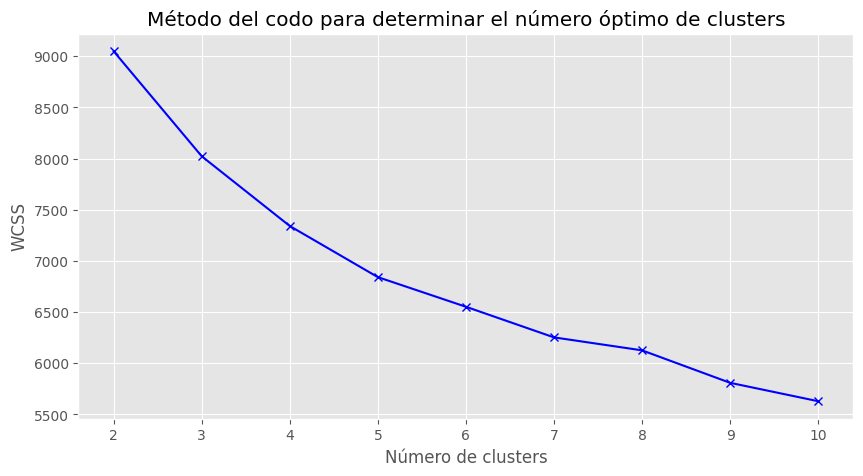

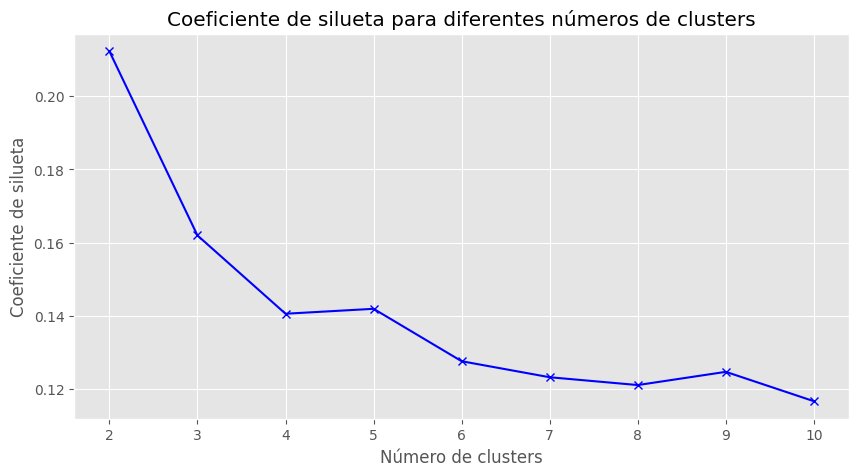

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determinar el número óptimo de clusters usando el método del codo y el coeficiente de silueta
wcss = []
silhouette_scores = []
K = range(2, 11)  # Evaluamos entre 2 y 10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(variables_pca_combinadas)
    wcss.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(variables_pca_combinadas, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Gráfico del método del codo
plt.figure(figsize=(10, 5))
plt.plot(K, wcss, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.title('Método del codo para determinar el número óptimo de clusters')
plt.show()

# Gráfico del coeficiente de silueta
plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente de silueta')
plt.title('Coeficiente de silueta para diferentes números de clusters')
plt.show()

# Seleccionar el número óptimo de clusters (por ejemplo, k=3)
k_optimo = 3
kmeans = KMeans(n_clusters=k_optimo, random_state=1234)
clusters = kmeans.fit_predict(variables_pca_combinadas)

# Añadir los clusters al dataframe
datos_combinados['Cluster'] = clusters


In [ ]:
# Descripción de los clusters
cluster_summary = datos_combinados.groupby('Cluster').mean(numeric_only=True)

print(cluster_summary)


               time      Speed          HR          VO2         VCO2  \
Cluster                                                                
0        637.450731  10.326262  151.325716  2618.077464  2676.090955   
1        528.622694   8.521120  150.030338  1736.031642  1760.172364   
2        647.086300   8.854796  137.312531  2248.898260  2421.483441   

                RR         VE          ID        Age     Weight      Height  \
Cluster                                                                       
0        37.606453  76.858693  365.901566  25.502685  77.764430  178.680984   
1        35.313118  53.307166  389.657692  25.324615  62.727692  167.631538   
2        32.308983  68.237145  549.550877  37.765614  76.232982  175.647719   

          Humidity  Temperature       Sex  
Cluster                                    
0        48.967293    23.369396  0.022371  
1        48.861923    23.164923  0.519231  
2        46.416491    21.643011  0.014035  


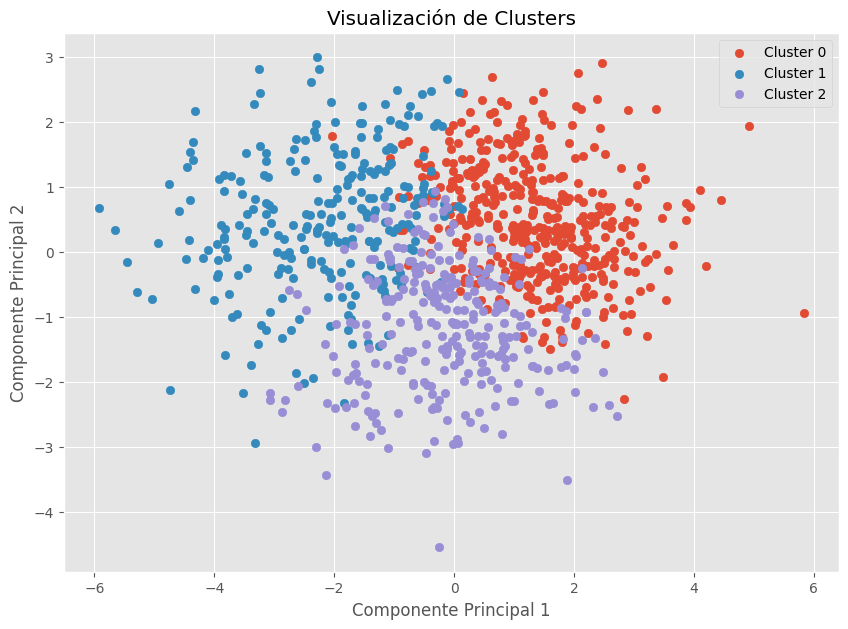

In [ ]:
# Visualizar los clusters en los primeros dos componentes
plt.figure(figsize=(10, 7))
for cluster in np.unique(clusters):
    plt.scatter(
        variables_pca_combinadas[clusters == cluster, 0],
        variables_pca_combinadas[clusters == cluster, 1],
        label=f'Cluster {cluster}'
    )

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización de Clusters')
plt.legend()
plt.show()


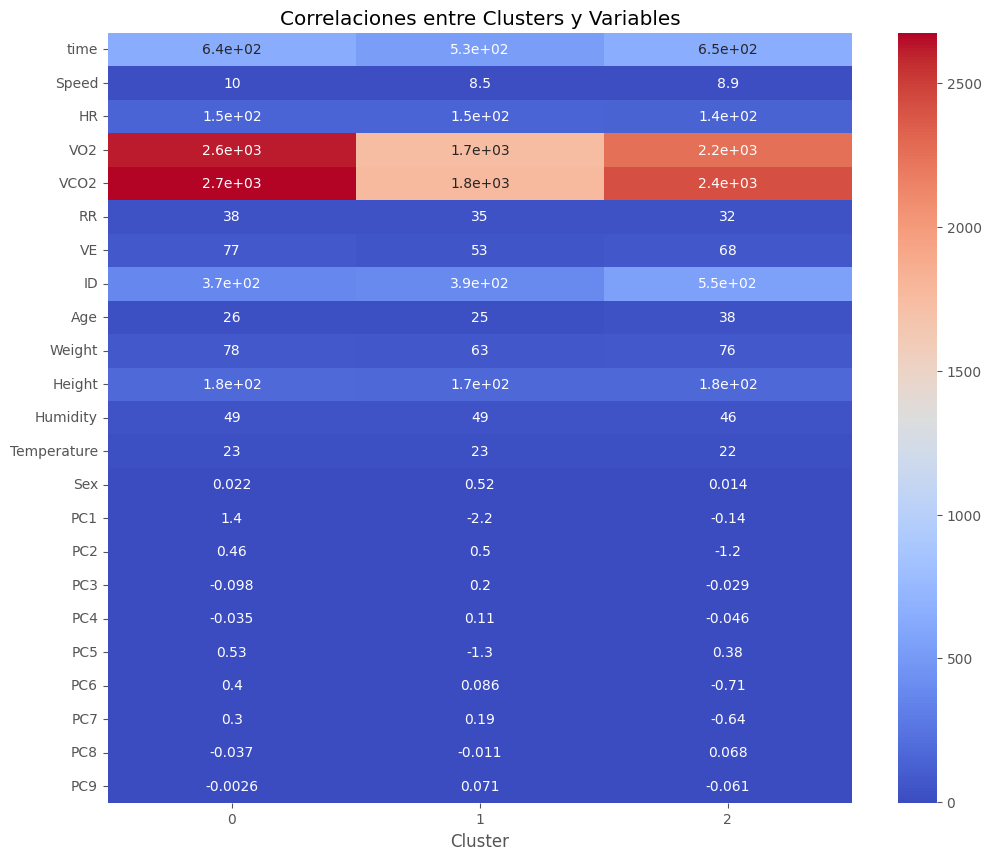

In [ ]:
# Añadir variables PCA al dataframe
for i in range(variables_pca_combinadas.shape[1]):
    datos_combinados[f'PC{i+1}'] = variables_pca_combinadas[:, i]

# Calcular correlaciones entre variables y clusters
correlaciones = datos_combinados.groupby('Cluster').mean(numeric_only=True).T

# Visualizar correlaciones con un heatmap
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm')
plt.title('Correlaciones entre Clusters y Variables')
plt.show()


In [ ]:
# Seleccionar solo las columnas numéricas
import numpy as np

numeric_cols = datos_combinados.select_dtypes(include=[np.number]).columns

# Calcular la matriz de correlación
corr_matrix = datos_combinados[numeric_cols].corr()

# Mostrar la matriz de correlación
print(corr_matrix)

                 time     Speed        HR       VO2      VCO2        RR  \
time         1.000000  0.528507 -0.215190  0.357490  0.372524  0.061183   
Speed        0.528507  1.000000  0.183234  0.552355  0.448082  0.306159   
HR          -0.215190  0.183234  1.000000  0.055568  0.039337  0.225308   
VO2          0.357490  0.552355  0.055568  1.000000  0.889436  0.100640   
VCO2         0.372524  0.448082  0.039337  0.889436  1.000000  0.047685   
RR           0.061183  0.306159  0.225308  0.100640  0.047685  1.000000   
VE           0.341586  0.479420  0.044634  0.832684  0.850432  0.283399   
ID           0.181101 -0.168241 -0.156675 -0.044344  0.121983 -0.080533   
Age          0.096268 -0.184568 -0.523258 -0.030243  0.025413 -0.323087   
Weight      -0.021918  0.005099 -0.067216  0.570524  0.567838 -0.181977   
Height       0.172211  0.228563 -0.043319  0.603727  0.571521 -0.074870   
Humidity    -0.071413  0.022312  0.055523 -0.015409 -0.075267 -0.010182   
Temperature -0.050201  0.

In [ ]:
# Convertir la matriz de correlación en un DataFrame
corr_pairs = corr_matrix.unstack().reset_index()
corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlación']

# Eliminar duplicados y correlaciones de una variable consigo misma
corr_pairs = corr_pairs[corr_pairs['Variable 1'] != corr_pairs['Variable 2']]
corr_pairs.drop_duplicates(subset=['Correlación'], inplace=True)

# Ordenar por valor absoluto de la correlación
corr_pairs['Correlación_abs'] = corr_pairs['Correlación'].abs()
corr_pairs.sort_values('Correlación_abs', ascending=False, inplace=True)

# Mostrar las correlaciones más significativas
print(corr_pairs.head(10))


      Variable 1 Variable 2  Correlación  Correlación_abs
235       Weight        PC5     0.924399         0.924399
87           VO2        PC1     0.914698         0.914698
159           VE        PC1     0.900826         0.900826
111         VCO2        PC1     0.895415         0.895415
259       Height        PC5     0.893492         0.893492
76           VO2       VCO2     0.889436         0.889436
102         VCO2         VE     0.850432         0.850432
78           VO2         VE     0.832684         0.832684
285     Humidity        PC7     0.809605         0.809605
308  Temperature        PC6     0.787167         0.787167


In [ ]:
from scipy.stats import pearsonr

# Función para calcular la correlación y el p-valor
def calculate_correlations(df, variables):
    correlations = []
    for var1 in variables:
        for var2 in variables:
            if var1 != var2:
                corr_coef, p_value = pearsonr(df[var1], df[var2])
                correlations.append({
                    'Variable 1': var1,
                    'Variable 2': var2,
                    'Correlación': corr_coef,
                    'P-valor': p_value
                })
    return pd.DataFrame(correlations)

# Calcular correlaciones y p-valores
variables = numeric_cols.tolist()
corr_pvalues = calculate_correlations(datos_combinados, variables)

# Filtrar correlaciones significativas (p-valor < 0.05)
significant_correlations = corr_pvalues[corr_pvalues['P-valor'] < 0.05]

# Ordenar por valor absoluto de la correlación
significant_correlations['Correlación_abs'] = significant_correlations['Correlación'].abs()
significant_correlations.sort_values('Correlación_abs', ascending=False, inplace=True)

# Mostrar las correlaciones significativas más fuertes
print(significant_correlations.head(10))


    Variable 1 Variable 2  Correlación  P-valor  Correlación_abs
446        PC5     Weight     0.924399      0.0         0.924399
225     Weight        PC5     0.924399      0.0         0.924399
83         VO2        PC1     0.914698      0.0         0.914698
348        PC1        VO2     0.914698      0.0         0.914698
152         VE        PC1     0.900826      0.0         0.900826
351        PC1         VE     0.900826      0.0         0.900826
349        PC1       VCO2     0.895415      0.0         0.895415
106       VCO2        PC1     0.895415      0.0         0.895415
447        PC5     Height     0.893492      0.0         0.893492
248     Height        PC5     0.893492      0.0         0.893492


In [ ]:
from scipy.stats import f_oneway

variables = numeric_cols.tolist()
cluster_labels = datos_combinados['Cluster'].unique()

# Crear un diccionario para almacenar los resultados
anova_results = []

for var in variables:
    groups = [datos_combinados[datos_combinados['Cluster'] == cluster][var] for cluster in cluster_labels]
    f_stat, p_value = f_oneway(*groups)
    anova_results.append({
        'Variable': var,
        'F-Statistic': f_stat,
        'P-valor': p_value
    })

anova_df = pd.DataFrame(anova_results)

# Filtrar variables con diferencias significativas entre clusters (p-valor < 0.05)
significant_vars_clusters = anova_df[anova_df['P-valor'] < 0.05]

# Ordenar por F-Statistic
significant_vars_clusters.sort_values('F-Statistic', ascending=False, inplace=True)

print("Variables con diferencias significativas entre clusters:")
print(significant_vars_clusters)


Variables con diferencias significativas entre clusters:
       Variable  F-Statistic        P-valor
14      Cluster          inf   0.000000e+00
15          PC1   814.723565  7.978154e-210
3           VO2   754.974431  8.581186e-200
4          VCO2   620.021912  3.019361e-175
6            VE   564.196185  3.279455e-164
16          PC2   302.858687  2.497261e-103
13          Sex   301.867220  4.620290e-103
19          PC5   285.181305   1.630111e-98
10       Height   236.868791   8.907825e-85
1         Speed   228.243352   3.144801e-82
8           Age   218.915632   1.937792e-79
9        Weight   195.137710   3.691036e-72
2            HR   162.907489   7.014558e-62
0          time   117.332181   1.886049e-46
20          PC6   113.900663   3.043947e-45
21          PC7    91.994992   2.283142e-37
5            RR    79.884559   6.909876e-33
7            ID    59.280671   4.838320e-25
12  Temperature    40.034895   1.910165e-17
11     Humidity     9.115023   1.195192e-04
17          PC3    

#PCR




Número de componentes que explican el 95% de la varianza: 3
RMSE Entrenamiento: 204.99
RMSE Prueba: 192.21
R^2 Entrenamiento: 0.81
R^2 Prueba: 0.82
RMSE Prueba (LR): 183.90
R^2 Prueba (LR): 0.83
Cargas de los componentes principales:


,Weight,Height,VE,VCO2
PC1,0.479141,0.482230,0.511358,0.525729
PC2,0.529237,0.505366,-0.522248,-0.437917
PC3,-0.697545,0.715518,0.015015,-0.035189


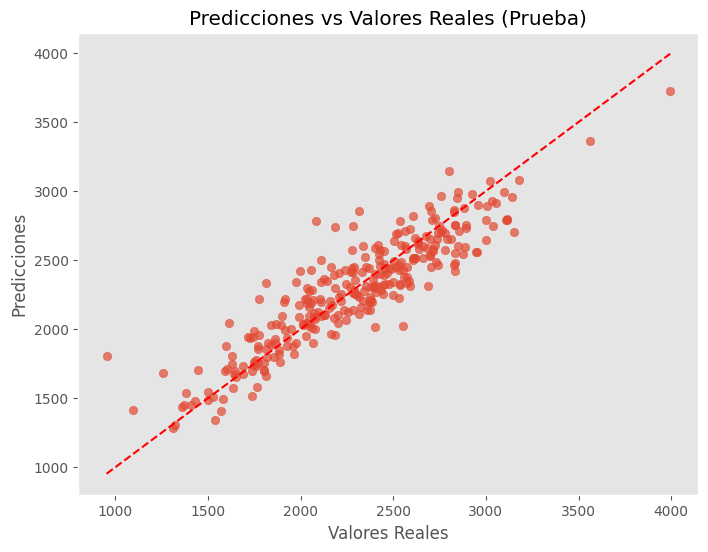

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Variables seleccionadas
variables_predictoras = ['Weight', 'Height', 'VE', 'VCO2']
variable_objetivo = 'VO2'

# Crear DataFrames con las variables seleccionadas
X = datos_combinados[variables_predictoras]
y = datos_combinados[variable_objetivo]

# Manejar datos faltantes (si es necesario)
X = X.dropna()
y = y[X.index]  # Alinear y con X después de eliminar nulos en X

# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=1234, shuffle=True
)

# Estandarización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA
pca = PCA()
pca.fit(X_train_scaled)

# Varianza explicada acumulada
varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)
n_componentes = np.argmax(varianza_acumulada >= 0.95) + 1
print(f"Número de componentes que explican el 95% de la varianza: {n_componentes}")

# Aplicar PCA con n_componentes
pca = PCA(n_components=n_componentes)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Modelo PCR
modelo_pcr = LinearRegression()
modelo_pcr.fit(X_train_pca, y_train)

# Predicciones
y_pred_train = modelo_pcr.predict(X_train_pca)
y_pred_test = modelo_pcr.predict(X_test_pca)

# Métricas
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"RMSE Entrenamiento: {rmse_train:.2f}")
print(f"RMSE Prueba: {rmse_test:.2f}")
print(f"R^2 Entrenamiento: {r2_train:.2f}")
print(f"R^2 Prueba: {r2_test:.2f}")

# Modelo de Regresión Lineal Estándar
modelo_lr = LinearRegression()
modelo_lr.fit(X_train_scaled, y_train)
y_pred_test_lr = modelo_lr.predict(X_test_scaled)
rmse_test_lr = mean_squared_error(y_test, y_pred_test_lr, squared=False)
r2_test_lr = r2_score(y_test, y_pred_test_lr)
print(f"RMSE Prueba (LR): {rmse_test_lr:.2f}")
print(f"R^2 Prueba (LR): {r2_test_lr:.2f}")

# Cargas de los componentes
componentes = pd.DataFrame(
    pca.components_,
    columns=variables_predictoras,
    index=[f'PC{i+1}' for i in range(n_componentes)]
)
print("Cargas de los componentes principales:")
display(componentes)

# Gráfico de Predicciones vs Valores Reales
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales (Prueba)')
plt.grid()
plt.show()
